In [1]:
import ezc3d
walk_2 = ezc3d.c3d("/Users/harrietdray/Biodynamics/Harriet_c3d/Walk-002/pose_filt_0.c3d")
hop_single = ezc3d.c3d("/Users/harrietdray/Biodynamics/Harriet_c3d/HopSingle-001/pose_filt_0.c3d")
cmj_3 = ezc3d.c3d("/Users/harrietdray/Biodynamics/Harriet_c3d/CMJ-003/pose_filt_0.c3d")
triple_hop_2 = ezc3d.c3d("/Users/harrietdray/Biodynamics/Harriet_c3d/HopTriple-002/pose_filt_0.c3d")
pistol_1 = ezc3d.c3d("/Users/harrietdray/Biodynamics/Harriet_c3d/Pistol-001/pose_filt_0.c3d")
pistol_2 = ezc3d.c3d("/Users/harrietdray/Biodynamics/Harriet_c3d/Pistol-002/pose_filt_0.c3d")
squat_2 = ezc3d.c3d("/Users/harrietdray/Biodynamics/Harriet_c3d/Squat001-000/pose_filt_0.c3d")
jog = ezc3d.c3d("/Users/harrietdray/Biodynamics/Harriet_c3d/Jog-001/pose_filt_0.c3d")



import matplotlib.pyplot as plt

labels = squat_2['parameters']['POINT']['LABELS']['value'] # List of angle names



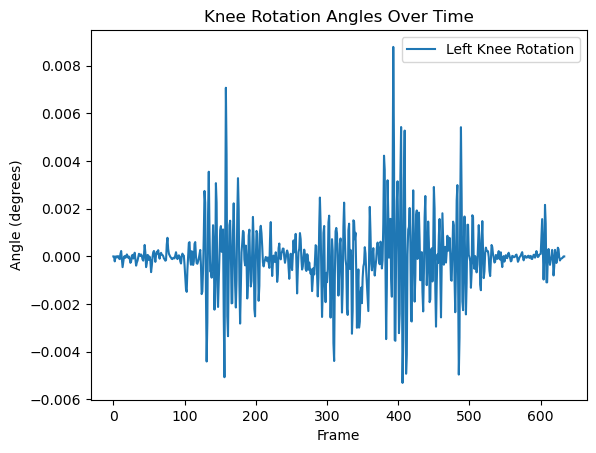

In [6]:
# Extracting angle data from the c3d file

angle_data = pistol_2['data']['points']

left_knee_idx = labels.index('LeftKneeAngles_Theia')
right_knee_idx = labels.index('RightKneeAngles_Theia')
left_hip_idx = labels.index('LeftHipAngles_Theia')
right_hip_idx = labels.index('RightHipAngles_Theia')
left_fp_idx = labels.index('LeftFootProgressionAngles_Theia')
right_fp_idx = labels.index('RightFootProgressionAngles_Theia')

# Extract the flexion angle values (shape: n_frames)
left_knee_flexion = -angle_data[0, left_knee_idx, :]
right_knee_flexion = angle_data[0, right_knee_idx, :]
left_hip_flexion = angle_data[0, left_hip_idx, :]
right_hip_flexion = angle_data[0, right_hip_idx, :]
left_fp_flexion = angle_data[0, left_fp_idx, :]
right_fp_flexion = angle_data[0, right_fp_idx, :]

#Extract the valgus/varus angle values (shape: n_frames)
left_knee_valgus = -angle_data[1, left_knee_idx, :]
right_knee_valgus = angle_data[1, right_knee_idx, :]
left_hip_valgus = angle_data[1, left_hip_idx, :]
right_hip_valgus = angle_data[1, right_hip_idx, :]
left_fp_valgus = angle_data[1, left_fp_idx, :]
right_fp_valgus = angle_data[1, right_fp_idx, :]

#Extract the internal/external rotation angle values (shape: n_frames)
left_knee_rotation = angle_data[2, left_knee_idx, :]
right_knee_rotation = angle_data[2, right_knee_idx, :]
left_hip_rotation = angle_data[2, left_hip_idx, :]
right_hip_rotation = angle_data[2, right_hip_idx, :]
left_fp_rotation = angle_data[2, left_fp_idx, :]
right_fp_rotation = angle_data[2, right_fp_idx, :]

#Plotting 
plt.plot(left_knee_rotation, label='Left Knee Rotation')
#plt.plot(right_knee_rotation, label='Right Knee Rotation')
plt.xlabel('Frame')
plt.ylabel('Angle (degrees)')
plt.title('Knee Rotation Angles Over Time')
plt.legend()
plt.show()
